In [1]:
import os, glob

import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
from tqdm import tqdm

In [2]:
%matplotlib notebook

In [3]:
# define result files
res_folder = '~/tmp/my_results/'
save_folder = '~/tmp/my_results/'

model_behav = 'res_v1_allBehavior.npy'
model_stim = 'res_v1_onlyShifter.npy'

data_behav = np.load( os.path.join(res_folder, model_behav), allow_pickle=True).item()
data_stim = np.load( os.path.join(res_folder, model_stim), allow_pickle=True).item()
keys = list( data_stim.keys() )
keys

['27204-5-13',
 '23343-5-17',
 '23964-4-22',
 '23656-14-22',
 '22846-10-16',
 '21067-10-18']

# Calculate global gain factor

### Calculate gain on training and validation data

In [4]:
def calculate_stimulus_gain(data_stim, key, thres=0.1, with_test=False):
    """ Extract average stimulus gain by comparing image-only model with recorded data
    
    Adrian 2022-09-30 """
    
    trial_type = data_stim[key]['trial_type']
    stim_mat = data_stim[key]['output']
    true_mat = data_stim[key]['target']

    nr_trials = true_mat.shape[0]
    nr_neurons = true_mat.shape[1]

    # gain including test set if available
    gain_all = np.zeros( (nr_trials, nr_neurons) ) * np.nan

    for n in range(nr_neurons):
        non_zero = true_mat[:,n] > thres
        gain_all[non_zero, n] = 1 - stim_mat[non_zero,n] / true_mat[non_zero,n]

    avg_gain_all = np.nanmean(gain_all, axis=1)

    # remove trials that are in test data
    avg_gain_train = np.copy( avg_gain_all )
    avg_gain_train[trial_type > 1] = np.nan
    
    if with_test == False:    
        return avg_gain_train
    else:
        return avg_gain_train, avg_gain_all

### Fit piecewise gaussian process to the data

In [5]:
def fit_piecewise_gaussian_process(signal, std=0.2, length_scale=5, nr_splits=10):
    """ Fit Gaussian process to interpolate nans in the signal
    Adrian 2022-09-30 """
    
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF

    interp_signal = np.zeros( len(signal) ) * np.nan
    index_signal = np.arange( len(signal) )

    nr_per_split = int(len(signal) / nr_splits) + 1

    for split in range(nr_splits):
        start = nr_per_split*split
        end = nr_per_split*(split+1)
        part_index = index_signal[start:end]

        # select data to fit gaussian process
        x_train = index_signal[np.max((0,start-50)):end+50]
        y_train = signal[np.max((0,start-50)):end+50]

        # remove nans (test data) from training data
        x_train = x_train[~np.isnan(y_train)]
        y_train = y_train[~np.isnan(y_train)]


        # fit Gaussian process
        kernel = 1 * RBF(length_scale=length_scale, length_scale_bounds='fixed')
        gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=std**2, n_restarts_optimizer=2)
        gaussian_process.fit(x_train.reshape(-1, 1), y_train)

        # evaluate fit at all indicies
        y_result = gaussian_process.predict(part_index.reshape(-1, 1))
        interp_signal[part_index] = y_result

    return interp_signal

  0%|          | 0/6 [00:00<?, ?it/s]/home/adhoff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


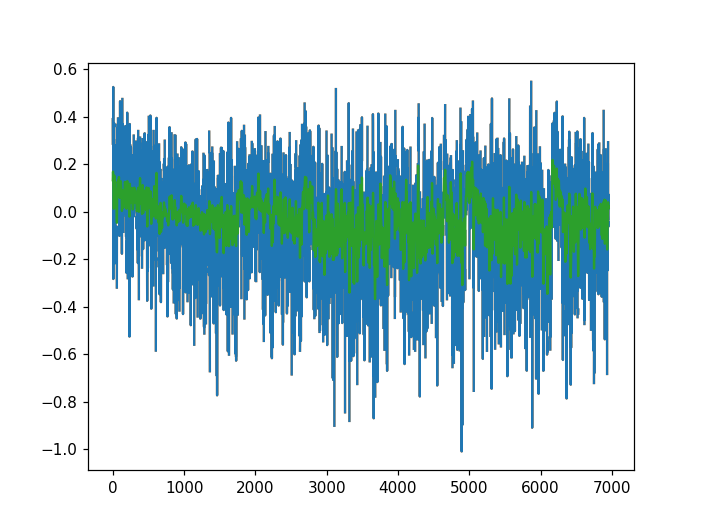

 17%|█▋        | 1/6 [00:18<01:31, 18.37s/it]

<IPython.core.display.Javascript object>


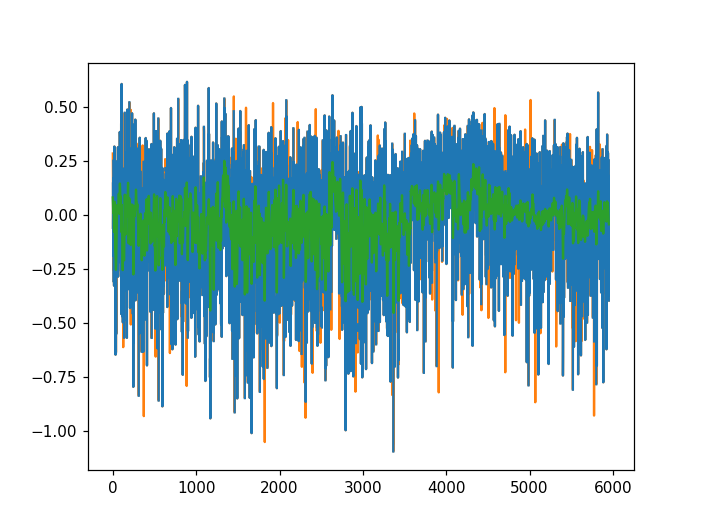

 33%|███▎      | 2/6 [00:34<01:08, 17.19s/it]

<IPython.core.display.Javascript object>


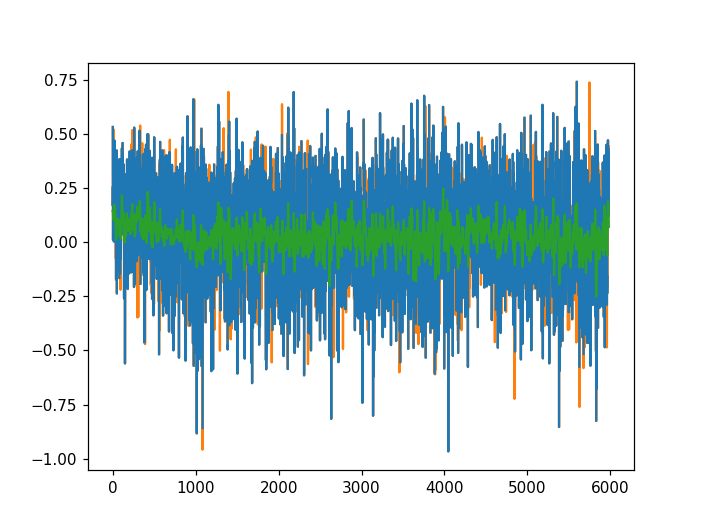

 50%|█████     | 3/6 [00:52<00:52, 17.45s/it]

<IPython.core.display.Javascript object>


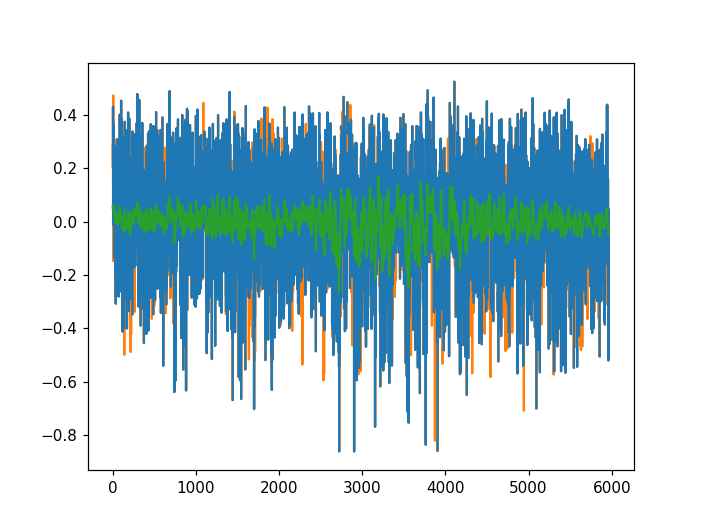

 67%|██████▋   | 4/6 [01:11<00:36, 18.03s/it]

<IPython.core.display.Javascript object>


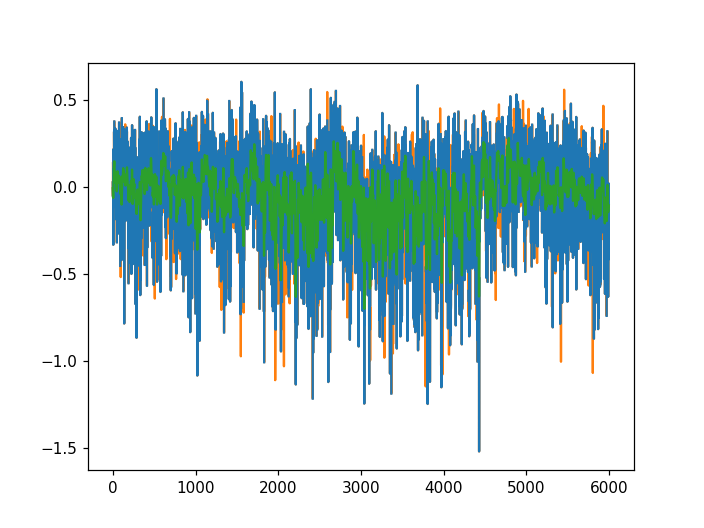

 83%|████████▎ | 5/6 [01:27<00:17, 17.39s/it]

<IPython.core.display.Javascript object>


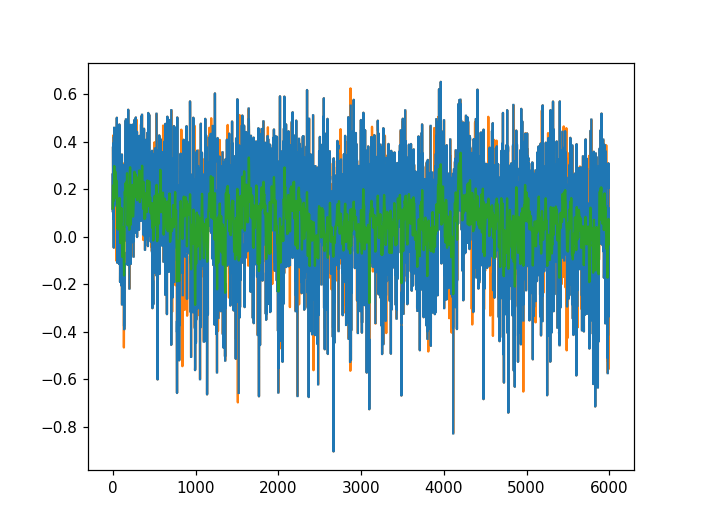

100%|██████████| 6/6 [01:43<00:00, 17.22s/it]


In [6]:
gains = dict()

for key in tqdm(keys):
    
    gain_train, gain_all = calculate_stimulus_gain(data_stim, key, thres=0.1, with_test=True)
    gain_interp = fit_piecewise_gaussian_process(signal=gain_train, std=0.2, length_scale=3, nr_splits=10)
    gains[key] = gain_interp
    
    plt.figure()
    plt.plot(gain_all, color='C1', label='Test Data')
    plt.plot(gain_train, color='C0', label='Train')
    plt.plot(gain_interp, label='Interpolation', color='C2')

### Save gains in order like training data

In [7]:
for key in keys:
    gain = gains[key]

    # these are the trial_ids sorted by time, like all other variables
    trial_id = data_stim[key]['trial_id']

    reordered_gain = np.zeros( len(gain) )
    for i, id_ in enumerate(trial_id):
        reordered_gain[id_] = gain[i]

    # add dimension for dataloader to work
    reordered_gain = np.expand_dims(reordered_gain, axis=1)
    np.save( os.path.join(save_folder, 'gain_{}.npy'.format(key)), reordered_gain)

### Test to find best smoothing parameter

In [8]:
# ls = np.arange(1,6)
# errors = list()
# for l_scale in ls:
#     interp_signal = fit_piecewise_gaussian_process(avg_gain_train, std=0.2, length_scale=l_scale, nr_splits=10)
#     error = np.sqrt( np.sum( np.square(interp_signal[test_select]-avg_gain_all[test_select])))
#     errors.append(error)

In [9]:
# plt.figure()
# plt.plot(ls, errors)

### Create recurrent signals

In [10]:
def create_recurrent_regressor(key, lag, data_stim):
    """ Create causal recurrent regressor which only uses training data points
    Adrian 2022-09-30 """

    inds = np.arange(-lag,0)   # e.g. [-2,-1] for lag 2

    trial_type = data_stim[key]['trial_type']
    true = data_stim[key]['target']   # (nr_trials, nr_neurons)
    
    nr_trials = true.shape[0]
    nr_neurons = true.shape[1]

    # zero padding at end to map negative indicies in inds to 0
    true_padded = np.concatenate( (true, np.zeros((lag+1, nr_neurons))) )
    history = np.zeros( (nr_trials, nr_neurons) )

    for i in range( len(trial_type) ):
        # add entry to hist vector
        history[i] = np.mean( true_padded[inds,:], axis=0 )

        # shift hist vector for next entry
        if trial_type[i] < 2:
            # data for this point is available => shifts inds
            inds[0:lag-1] = inds[1:]
            inds[-1] = i
        else:
            # otherwise do nothing, because true value is not available => keep last ones
            pass
    return history
        
def get_multiple_lags(key, lags, data_stim):
    """ Create 3d matrix with different history filters
    Adrian 2022-09-30 """
    
    true = data_stim[key]['target']   # (nr_trials, nr_neurons)
    nr_trials = true.shape[0]
    nr_neurons = true.shape[1]
    
    history_mat = np.zeros( (nr_trials, nr_neurons, len(lags)) )
    
    for i, lag in enumerate(lags):
        history_mat[:,:,i] = create_recurrent_regressor(key, lag, data_stim=data_stim)
        
    return history_mat

  0%|          | 0/6 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


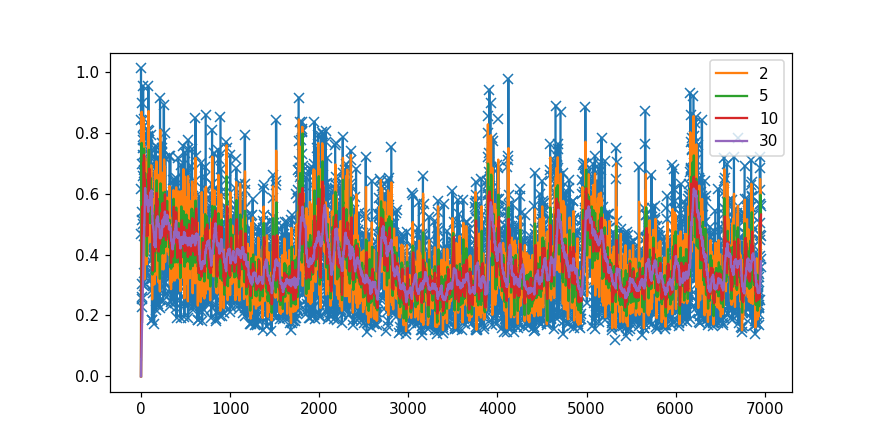

 17%|█▋        | 1/6 [00:04<00:22,  4.44s/it]

<IPython.core.display.Javascript object>


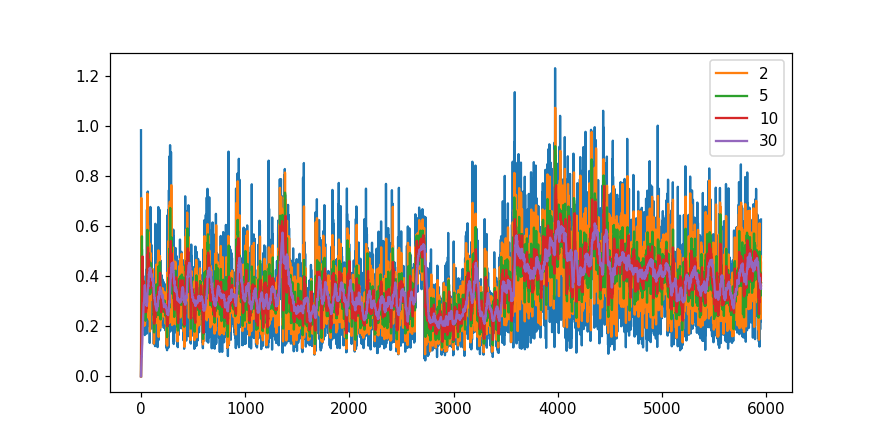

 33%|███▎      | 2/6 [00:08<00:16,  4.08s/it]

<IPython.core.display.Javascript object>


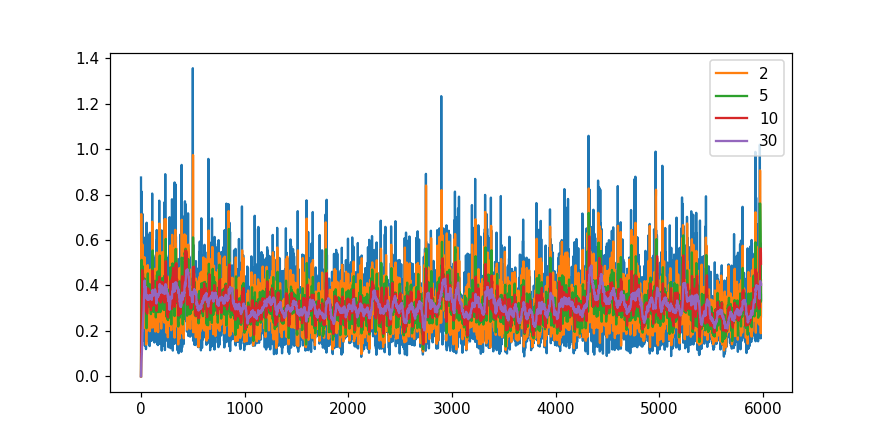

 50%|█████     | 3/6 [00:12<00:12,  4.02s/it]

<IPython.core.display.Javascript object>


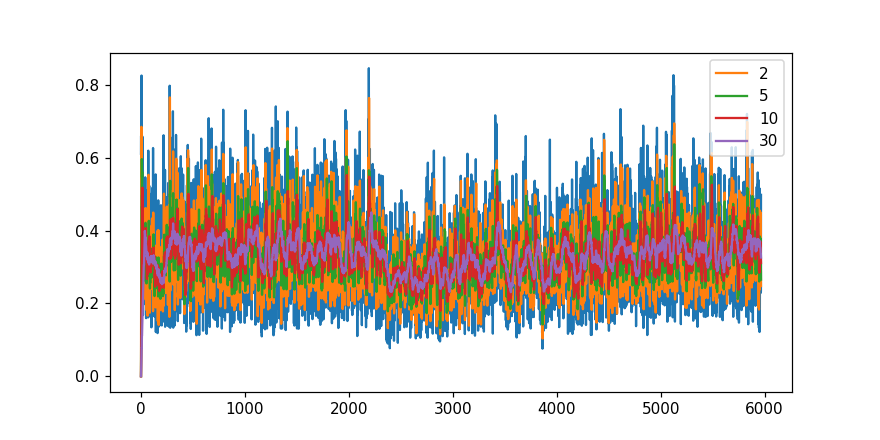

 67%|██████▋   | 4/6 [00:16<00:08,  4.02s/it]

<IPython.core.display.Javascript object>


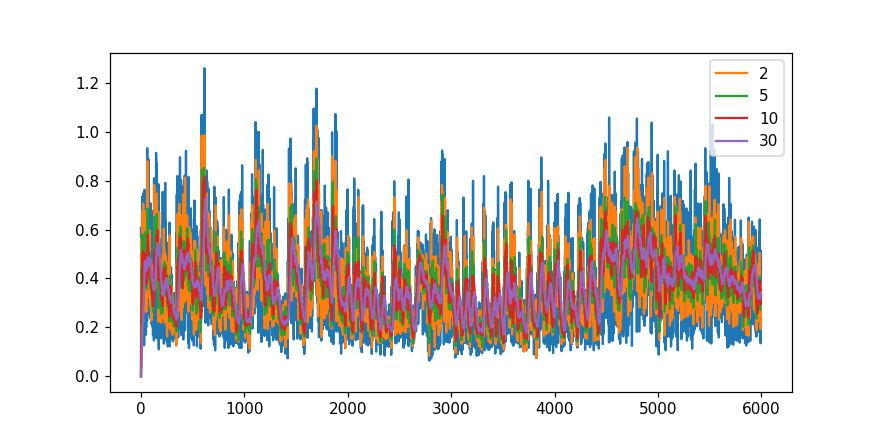

 83%|████████▎ | 5/6 [00:19<00:03,  3.81s/it]

<IPython.core.display.Javascript object>


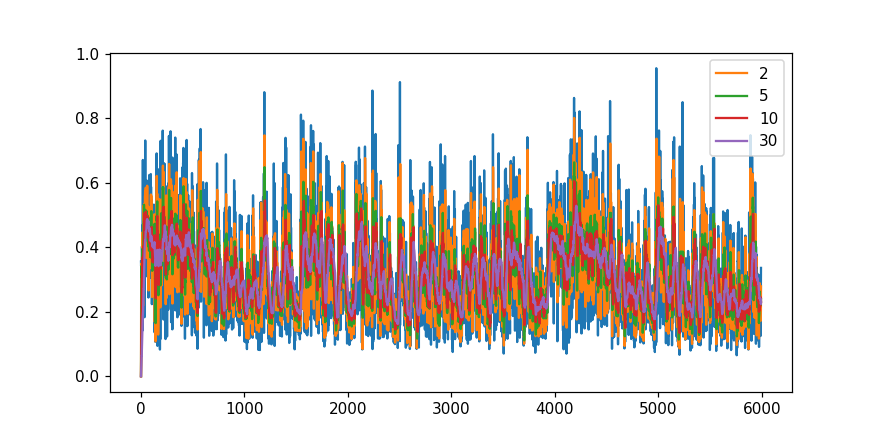

100%|██████████| 6/6 [00:23<00:00,  3.93s/it]


In [11]:
lags = [2,5,10,30]
history = dict()

for key in tqdm(keys):
    # get history values with different lags
    history_mat = get_multiple_lags(key, lags, data_stim)
    
    # for sanity check of data, plot average with history
    plt.figure(figsize=(8,4))
    true = np.mean( data_stim[key]['target'], axis=1 )
    if key == '27204-5-13':  # competition dataset with many 0s
        true[true==0] = np.nan
        plt.plot( true, 'x-' )
    else:
        plt.plot( true )
        
    for i, lag in enumerate(lags):
        plt.plot(np.mean(history_mat[:,:,i], axis=1), label=str(lag))
    plt.legend(loc='upper right')

    # these are the trial_ids sorted by time, like all other variables
    trial_id = data_stim[key]['trial_id']
    
    # shape: (nr_trials, nr_neurons, nr_lags)
    reordered_history = np.zeros_like( history_mat )
    for i, id_ in enumerate(trial_id):
        reordered_history[id_] = history_mat[i]
        
    # save matrix
    # np.save( os.path.join(save_folder, 'history_{}.npy'.format(key)), reordered_history)
    